In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based SEPP method(s)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

# With real data

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [4]:
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")
datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

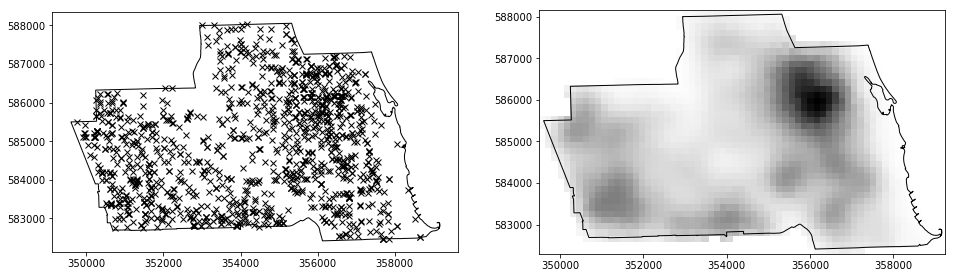

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

In [8]:
def add_random_noise(points):
    ts = points.timestamps + np.random.random(size=points.timestamps.shape) * 60 * 1000 * np.timedelta64(1,"ms")
    ts = np.sort(ts)
    return points.from_coords(ts, points.xcoords, points.ycoords)

In [9]:
trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1, timeunit=datetime.timedelta(days=1))
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)

In [10]:
model

ExpDecayModel(T=365.9582459606481, theta=0.0018056589040017516, omega=3.49834342500646, mu size=(39, 65), t0=1

In [11]:
pred = trainer.prediction_from_background(model)

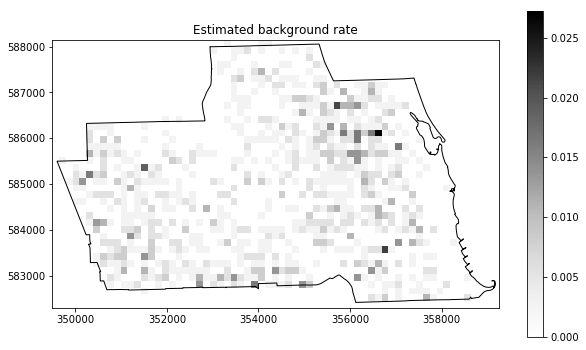

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")
None

In [13]:
np.max(model.mu), np.min(model.mu)

(0.027276661047638359, 0.0)

In [14]:
24 * 60 / model.omega

411.62339572117361

Unfortunately, the predicted parameters are not very "realistic".  The triggering kernel is
$$ g(t) = \theta \omega e^{-\omega t} $$
with time measured in "days".  We estimate $1 / \omega \approx 419$ _minutes_, and $\theta$ is small.   This means that events need to be very near in time before the triggering kernel adds much.

In [15]:
trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1, timeunit=datetime.timedelta(days=1))
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)

In [16]:
model

ExpDecayModel(T=365.9583333333333, theta=0.0018231357721467739, omega=3.4357032149069715, mu size=(39, 65), t0=1

In [17]:
24 * 60 / model.omega

419.12816967195198

# Other regions of chicago

Notice how small $\theta$ gets!

In [18]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [19]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2010-01-01")) & (all_points.timestamps < np.datetime64("2011-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

def train(grid, points):
    trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1)
    trainer.data = add_random_noise(points)
    model = trainer.train(datetime.datetime(2011,1,1), iterations=50)
    return model

In [20]:
for side in sides:
    model = train(*load(side))
    print(side, model.theta, 1/model.omega, np.max(model.mu))

Far North 1.3124392937e-14 5.55618467322 0.0274035565887
Northwest 9.26629124057e-13 5.20496679775 0.0356334394456
North 1.83081480918e-07 2.58477219452 0.0328805179777
West 0.00271659062372 1.36149437185 0.0519856034368
Central 4.20210039314e-07 3.79085729016 0.0219766304948
South 0.00797703999089 0.590213454758 0.0654924003206
Southwest 8.10117513626e-07 4.79992940954 0.0547944771935
Far Southwest 9.82063363144e-05 0.770147365966 0.043880641626
Far Southeast 0.00339550367582 0.370705446551 0.0707993747905


# Vary the `cutoff`

Computationally expensive.

In [21]:
grid, points = load("South")

In [22]:
trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=1)
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2011,1,1), iterations=50)
model

ExpDecayModel(T=364.99981116898147, theta=0.007837115842758806, omega=1.553145316750897, mu size=(80, 70), t0=1

In [23]:
model = trainer.train(datetime.datetime(2011,1,1), iterations=100)
model

ExpDecayModel(T=364.99981116898147, theta=0.0073681608693305515, omega=1.7524874138270927, mu size=(80, 70), t0=1

In [24]:
model = trainer.train(datetime.datetime(2011,1,1), iterations=200)
model

ExpDecayModel(T=364.99981116898147, theta=0.007358958593904248, omega=1.7564274082485916, mu size=(80, 70), t0=1

In [25]:
cutoff = [0.1, 0.2, 0.5, 1, 1.5, 2]
lookup = {}
for c in cutoff:
    trainer = sepp.sepp_grid.ExpDecayTrainerWithCutoff(grid, cutoff=c)
    trainer.data = add_random_noise(points)
    model = trainer.train(datetime.datetime(2011,1,1), iterations=100)
    lookup[c] = model

In [26]:
lookup

{0.1: ExpDecayModel(T=364.99973059027775, theta=0.017214038738470227, omega=1.6047075916202125, mu size=(80, 70), t0=0.1,
 0.2: ExpDecayModel(T=364.9995791898148, theta=0.014804577834317937, omega=1.5675253608200053, mu size=(80, 70), t0=0.2,
 0.5: ExpDecayModel(T=364.9999560648148, theta=0.009736921021275368, omega=0.7470621477977646, mu size=(80, 70), t0=0.5,
 1: ExpDecayModel(T=364.9998717824074, theta=0.007501548842445626, omega=1.9163195504907453, mu size=(80, 70), t0=1,
 1.5: ExpDecayModel(T=364.9994372106481, theta=0.0033498811591053898, omega=2.1201156789010476, mu size=(80, 70), t0=1.5,
 2: ExpDecayModel(T=364.99970072916665, theta=0.002505566536670226, omega=10.835913125915296, mu size=(80, 70), t0=2}

In [27]:
pred = trainer.prediction_from_background(lookup[0.1])
pred.mask_with(grid)
pred = pred.renormalise()

pred1 = trainer.prediction_from_background(lookup[0.5])
pred1.mask_with(grid)
pred1 = pred1.renormalise()

np.max(np.abs(pred.intensity_matrix - pred1.intensity_matrix))

0.00045298318561906191